In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import json 

import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from preprocessor import get_train_environment

# Tuning model

In [2]:
# Define parameter grid
n_estimators = list(range(100, 1100, 100))
max_depth = list(range(3, 11, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = None
best_score = float('inf')
model_performance = []

# Iterate over all combinations of parameters
for n, d in param_grid:
    mse_scores = []
    print(n,d)
    
    # Iterate over folds
    envGen = get_train_environment(n_splits=5)
    stats, X, X_holdout, y, y_holdout = next(envGen)
    
    for fold, stats, X_train, X_test, y_train, y_test in envGen:
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping empty fold: {fold}")
            continue

        # Create and fit the model
        model = XGBRegressor(n_estimators=n, max_depth=d)
        model.fit(X_train, y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        # Check if predictions are valid
        if not np.any(np.isnan(predictions)):
            mse = mean_squared_error(y_test, predictions)
            # print("Mean Squared Error: ", mse)
            mse_scores.append(mse)
            performance = {
                'n_estimators': n,
                'max_depth': d,
                'Fold':fold,
                'MSE': mse
            }
            model_performance.append(performance)
        else:
            print(f"Invalid predictions in fold: {fold}")       

    # Average MSE across folds for current parameter combination
    avg_mse = np.mean(mse_scores)
    # Update best parameters if current combination is better
    if avg_mse < best_score:
        best_score = avg_mse
        best_params = (n, d)


100 3
Found cached folds, using those
100 4
Found cached folds, using those
100 5
Found cached folds, using those
100 6
Found cached folds, using those
100 7
Found cached folds, using those
100 8
Found cached folds, using those
100 9
Found cached folds, using those
100 10
Found cached folds, using those
200 3
Found cached folds, using those
200 4
Found cached folds, using those
200 5
Found cached folds, using those
200 6
Found cached folds, using those
200 7
Found cached folds, using those
200 8
Found cached folds, using those
200 9
Found cached folds, using those
200 10
Found cached folds, using those
300 3
Found cached folds, using those
300 4
Found cached folds, using those
300 5
Found cached folds, using those
300 6
Found cached folds, using those
300 7
Found cached folds, using those
300 8
Found cached folds, using those
300 9
Found cached folds, using those
300 10
Found cached folds, using those
400 3
Found cached folds, using those
400 4
Found cached folds, using those
400 5
Fou

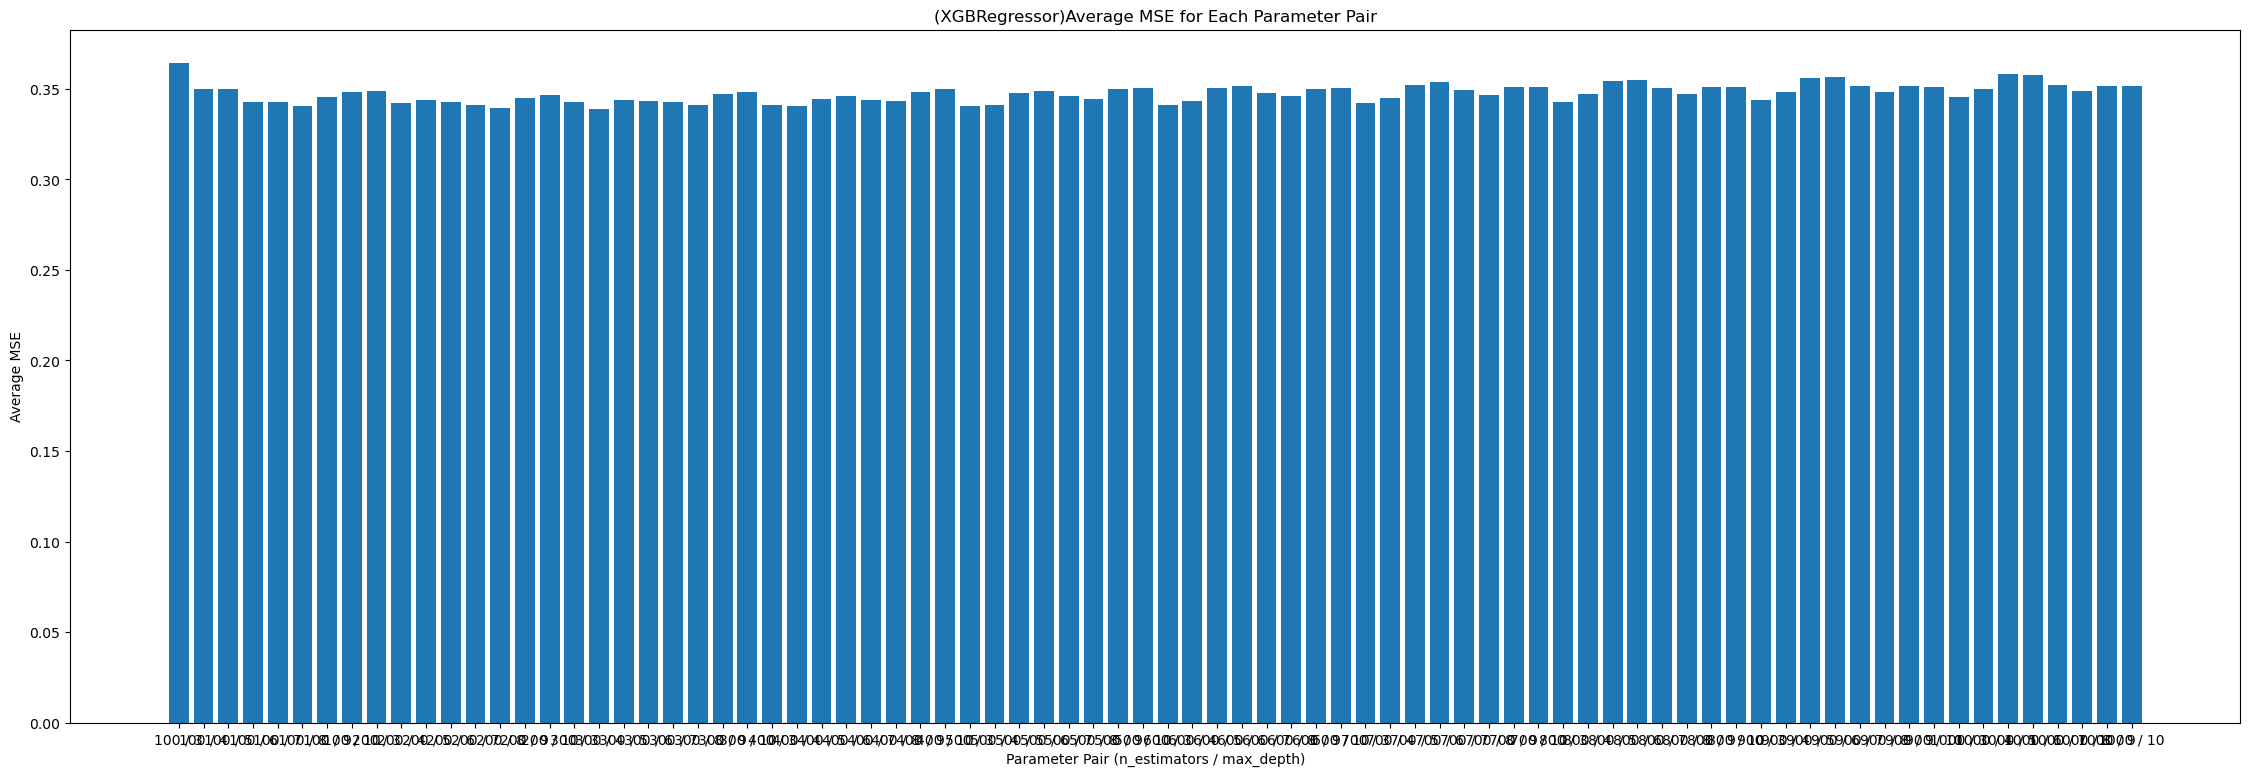

In [3]:
# Aggregate MSE values for each (n_estimators, max_depth) pair
mse_aggregate = {}

for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in mse_aggregate:
        mse_aggregate[key] = []
    mse_aggregate[key].append(entry['MSE'])

# Calculate average MSE for each pair
average_mse = {k: sum(v)/len(v) for k, v in mse_aggregate.items()}

# Prepare data for plotting
n_estimators = [k[0] for k in average_mse.keys()]
max_depth = [k[1] for k in average_mse.keys()]
avg_mse = list(average_mse.values())

plt.figure(figsize=(28,9))
plt.bar(range(len(avg_mse)), avg_mse, tick_label=[f"{n} / {d}" for n, d in zip(n_estimators, max_depth)])
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average MSE')
plt.title('(XGBRegressor)Average MSE for Each Parameter Pair')
plt.show()

In [4]:
print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with MSE: {best_score}")

Best parameters: n_estimators=300, max_depth=4 with MSE: 0.33874009404870986


# Find important feature

In [5]:
envGen = get_train_environment(n_splits=5)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Initialize variables to track important features num
print(len(X[0]))
featureNums = range(1, len(X[0]), 10)
featureNumMSEs = {}

# Cross validation folds
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    print(f"Fold: {fold}")
    
    model = XGBRegressor(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train, y_train)

    # print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print("Overall Fold Mean Squared Error: ", mse)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    eps = 0.000001
    lastMSE = None
    for featureNum in featureNums:
        selectedFeatures = [i for i, x in thresholds[:featureNum]]
        
        model = XGBRegressor(n_estimators=best_params[0], max_depth=best_params[1])
        XT = X_train[:, selectedFeatures]
        model.fit(XT, y_train)
        
        predictions = model.predict(X_test[:, selectedFeatures])
        mse = mean_squared_error(y_test, predictions)
        
        if lastMSE is not None:
            if np.abs(mse - lastMSE) < eps:
                print(np.abs(mse - lastMSE))
                print(mse)
                break
            else:
                lastMSE = mse
        else:
            lastMSE = mse
        
        if featureNum in featureNumMSEs:
            featureNumMSEs[featureNum].append(mse)
        else:
            featureNumMSEs[featureNum] = [mse]
        
        print(f"FeatureNum: {featureNum}")
        print("FeatureNum Mean Squared Error: ", mse)

avgFeatureNumMSEs = {x: np.mean(featureNumMSEs[x]) for x in featureNumMSEs}
optimal_FeatureNum = [min(avgFeatureNumMSEs, key=avgFeatureNumMSEs.get),avgFeatureNumMSEs[min(avgFeatureNumMSEs, key=avgFeatureNumMSEs.get)]]
print("Optimal # of features: ",optimal_FeatureNum[0],", MSE: ",optimal_FeatureNum[1])

Found cached folds, using those
1574
Fold: 0
Overall Fold Mean Squared Error:  0.3412138115975288
FeatureNum: 1
FeatureNum Mean Squared Error:  0.9692065239694542
FeatureNum: 11
FeatureNum Mean Squared Error:  0.516527716414906
FeatureNum: 21
FeatureNum Mean Squared Error:  0.4756144286442663
FeatureNum: 31
FeatureNum Mean Squared Error:  0.4343441034933387
FeatureNum: 41
FeatureNum Mean Squared Error:  0.4323541558539267
FeatureNum: 51
FeatureNum Mean Squared Error:  0.41932567998830966
FeatureNum: 61
FeatureNum Mean Squared Error:  0.4070916346588201
FeatureNum: 71
FeatureNum Mean Squared Error:  0.41056793214233933
FeatureNum: 81
FeatureNum Mean Squared Error:  0.4037047043598306
FeatureNum: 91
FeatureNum Mean Squared Error:  0.3973185056587767
FeatureNum: 101
FeatureNum Mean Squared Error:  0.39741461595176275
FeatureNum: 111
FeatureNum Mean Squared Error:  0.3768722895903619
FeatureNum: 121
FeatureNum Mean Squared Error:  0.3726561130983322
FeatureNum: 131
FeatureNum Mean Squared 

Text(0.5, 1.0, 'XGBRegressor feature number vs MSE')

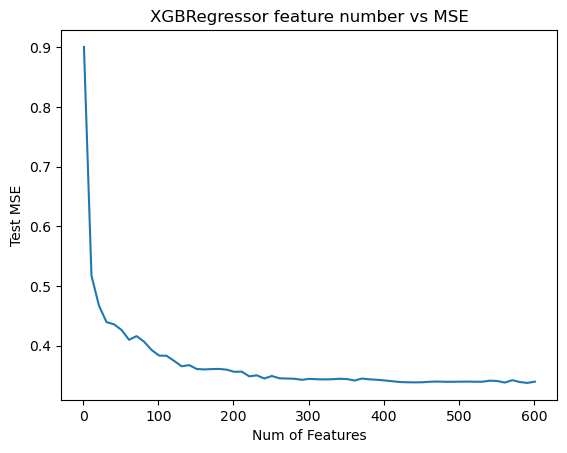

In [6]:
ax = sns.lineplot(pd.Series(avgFeatureNumMSEs))
ax.set_xlabel("Num of Features")
ax.set_ylabel("Test MSE")
ax.set_title("XGBRegressor feature number vs MSE")

# Create final XGBRegressor model after tuning & select important features

In [4]:
envGen = get_train_environment(n_splits=50)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

final_mses = []
final_selection_intersection = set()
allSelecteds = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    
    model = XGBRegressor(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train_fold, y_train_fold)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    pre_predictions = model.predict(X_test_fold)

    pre_mse = mean_squared_error(y_test_fold, pre_predictions)
    print("Pre Selection MSE: ", pre_mse)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    selectedFeatures = [i for i, x in thresholds[:optimal_FeatureNum[0]]]
    allSelecteds.append(selectedFeatures)
    
    if len(final_selection_intersection) == 0:
        final_selection_intersection = final_selection_intersection.union(selectedFeatures)
    else:
        final_selection_intersection = final_selection_intersection.intersection(selectedFeatures)
    
    model = XGBRegressor(n_estimators=best_params[0], max_depth=best_params[1])
    
    XT = X_train_fold[:, selectedFeatures]
    model.fit(XT, y_train_fold)

    post_predictions = model.predict(X_test_fold[:, selectedFeatures])
    post_mse = mean_squared_error(y_test_fold, post_predictions)
    print("Post Selection MSE: ", post_mse)
    final_mses.append(post_mse)

Found cached folds, using those
Fold: 0
[0.00098085 0.00267424 0.00061071 ... 0.00352234 0.00141223 0.00484692]
Pre Selection MSE:  0.30239127869199456
Post Selection MSE:  0.27851810978879077
Fold: 1
[0.00088905 0.00334518 0.00084227 ... 0.00740847 0.00188005 0.00536917]
Pre Selection MSE:  0.4724832442675739
Post Selection MSE:  0.47539423126178026
Fold: 2
[0.001002   0.00305233 0.0006248  ... 0.00180352 0.00139157 0.00497145]
Pre Selection MSE:  0.43701549953233954
Post Selection MSE:  0.41560975209924295
Fold: 3
[0.00099819 0.00379898 0.00052764 ... 0.00103241 0.00130296 0.00527149]
Pre Selection MSE:  0.34556986103253506
Post Selection MSE:  0.32825821973340213
Fold: 4
[0.00104794 0.00373326 0.00054908 ... 0.00568294 0.00126665 0.00504036]
Pre Selection MSE:  0.2961894187294267
Post Selection MSE:  0.2708911077044518
Fold: 5
[0.00094993 0.00377614 0.00045932 ... 0.00284983 0.00180894 0.00490444]
Pre Selection MSE:  0.4413566187689015
Post Selection MSE:  0.4248188018957671
Fold: 6

In [5]:
print("Final XGBRegressor model's avg. MSE:",np.mean(final_mses))

Final XGBRegressor model's avg. MSE: 0.3403815529845174


Text(0.5, 1.0, 'Final XGBoost Regressor Model CV Results')

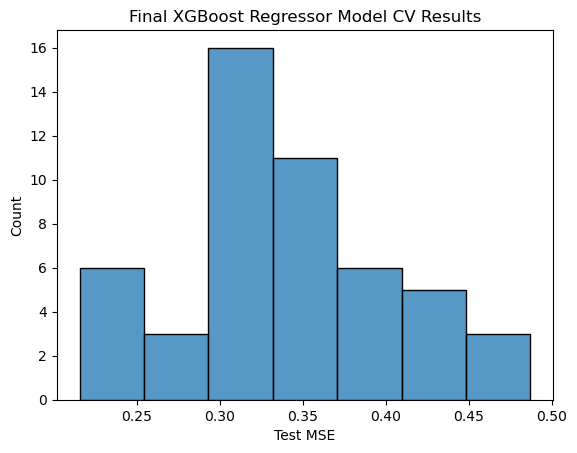

In [7]:
ax = sns.histplot(final_mses)
ax.set_xlabel("Test MSE")
ax.set_title("Final XGBoost Regressor Model CV Results")

In [ ]:
def feature_labels(features):
    data = pd.read_csv("FinalData.csv")
    data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
    data_columns = data.columns.tolist()
    return [x for i, x in enumerate(data_columns) if i in features]

In [10]:
rf_reg_final_features = feature_labels(final_selection_intersection)
print(rf_reg_final_features)

['release_date', 'Single-player', 'Online Co-op', 'Shared/Split Screen Co-op', 'Steam Achievements', 'Full controller support', 'Steam Trading Cards', 'Captions available', 'Steam Workshop', 'Steam Cloud', 'Stats', 'Commentary available', 'Remote Play on Phone', 'Remote Play on TV', 'Remote Play Together', 'tag_Puzzle', 'tag_Dark Humor', 'tag_Story Rich', 'genre_Action', 'genre_Adventure', 'tag_Sandbox', 'tag_Gore', 'tag_Physics', 'genre_Casual', 'genre_Indie', 'genre_Simulation', 'tag_Action Roguelike', 'tag_Bullet Hell', 'tag_Pixel Graphics', 'tag_2D', 'genre_RPG', 'LAN Co-op', 'tag_Multiplayer', 'tag_RPG', 'tag_Indie', 'tag_Action', 'Partial Controller Support', 'Includes Source SDK', 'tag_3D Platformer', 'tag_Singleplayer', 'Online PvP', 'tag_Strategy', 'Tracked Controller Support', 'tag_Female Protagonist', 'tag_Shooter', 'Profile Features Limited', 'tag_Anime', 'tag_Cute', 'tag_Choose Your Own Adventure', 'tag_Memes', 'tag_Comedy', 'tag_Simulation', 'tag_Open World', 'tag_Early A